In [33]:
import pickle
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.stats import lognorm
from scipy.stats import norm
import math

In [23]:
graph = {}
with open('fb_graph.pkl', 'rb') as f:
    graph = pickle.load(f)
G = nx.from_dict_of_dicts(graph)

In [24]:
for i in range(len(G.nodes)):
    G.nodes[i]["status"] = "S"

In [4]:
G.nodes.data()

NodeDataView({0: {'status': 'S'}, 1: {'status': 'S'}, 2: {'status': 'S'}, 3: {'status': 'S'}, 4: {'status': 'S'}, 5: {'status': 'S'}, 6: {'status': 'S'}, 7: {'status': 'S'}, 8: {'status': 'S'}, 9: {'status': 'S'}, 10: {'status': 'S'}, 11: {'status': 'S'}, 12: {'status': 'S'}, 13: {'status': 'S'}, 14: {'status': 'S'}, 15: {'status': 'S'}, 16: {'status': 'S'}, 17: {'status': 'S'}, 18: {'status': 'S'}, 19: {'status': 'S'}, 20: {'status': 'S'}, 21: {'status': 'S'}, 22: {'status': 'S'}, 23: {'status': 'S'}, 24: {'status': 'S'}, 25: {'status': 'S'}, 26: {'status': 'S'}, 27: {'status': 'S'}, 28: {'status': 'S'}, 29: {'status': 'S'}, 30: {'status': 'S'}, 31: {'status': 'S'}, 32: {'status': 'S'}, 33: {'status': 'S'}, 34: {'status': 'S'}, 35: {'status': 'S'}, 36: {'status': 'S'}, 37: {'status': 'S'}, 38: {'status': 'S'}, 39: {'status': 'S'}, 40: {'status': 'S'}, 41: {'status': 'S'}, 42: {'status': 'S'}, 43: {'status': 'S'}, 44: {'status': 'S'}, 45: {'status': 'S'}, 46: {'status': 'S'}, 47: {'sta

In [5]:
len(list((nx.get_node_attributes(G,'status'))))

4039

In [6]:
c=0
for i in range(len(nx.degree_histogram(G))):
    if nx.degree_histogram(G)[i]>0:
        c=i
        
print(c)

1045


In [7]:
len(nx.degree_histogram(G))

1046

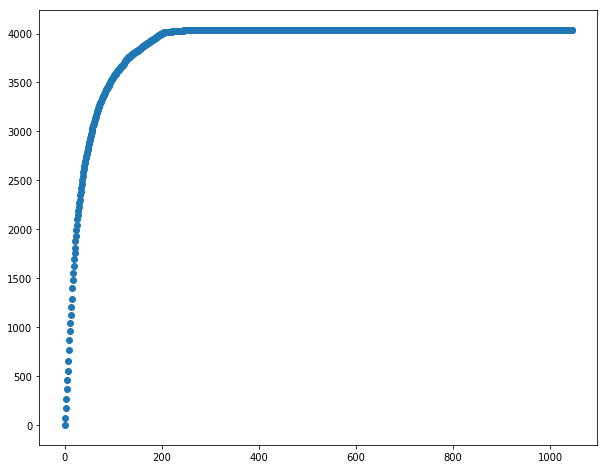

In [8]:
plt.figure(figsize=(10,8))
plt.scatter(list(range(len(nx.degree_histogram(G)))),np.cumsum(nx.degree_histogram(G)))

In [9]:
np.sum(np.multiply(np.array(list(range(len(nx.degree_histogram(G))))),np.array(nx.degree_histogram(G))))

176466

In [10]:
.2/43.7

0.004576659038901602

In [180]:
def run_iteration(G):
    S_n = [n for n,v in G.nodes(data=True) if v['status'] == 'S']
    E_n = [n for n,v in G.nodes(data=True) if v['status'] == 'E']
    I_n = [n for n,v in G.nodes(data=True) if v['status'] == 'I']
    H_n = [n for n,v in G.nodes(data=True) if v['status'] == 'H']
    for i in I_n:
        for neighbor in G.neighbors(i):
            if G.nodes[neighbor]["status"] == "S":
                if random.random() < 0.004576659038901602:
                    G.nodes[neighbor]["status"] = "E"
                    G.nodes[neighbor]["days_since_E"] = 0
    for e in E_n:
        G.nodes[e]["days_since_E"] += 1
        days_since_E = G.nodes[e]["days_since_E"]
        if days_since_E == 14: # if you've been asymp for 14 days, you recover
            G.nodes[e]["status"] = "R"
        mu = 1.621
        std = 0.418
        prob = lognorm.pdf(days_since_E, s=std, scale=np.exp(mu)) * 0.8
        if random.random() < prob:
            G.nodes[e]["status"] = "I"
            G.nodes[e]["days_since_I"] = 0
    for i in I_n:
        G.nodes[i]["days_since_E"] += 1
        G.nodes[i]["days_since_I"] += 1
        days_since_I = G.nodes[i]["days_since_I"]
        dist = norm(10, 1) 
        prob = dist.pdf(days_since_I) * 0.1755
        if random.random() < prob:
            G.nodes[i]["status"] = "H"
            G.nodes[i]["days_since_H"] = 0
    for h in H_n:
        G.nodes[h]["days_since_H"] += 1
        G.nodes[h]["days_since_E"] += 1
        if G.nodes[h]["days_since_E"] == 14:
            if random.random() < 0.01:
                G.nodes[h]["status"] = "D"
            else:
                G.nodes[h]["status"] = "R"

In [76]:
T = G.copy()
T.nodes[0]["status"] = "I"
T.nodes[0]["days_since_E"] = 0
T.nodes[0]["days_since_I"] = 0

In [183]:
for i in range(100):
    run_iteration(T)
S_n = [n for n,v in T.nodes(data=True) if v['status'] == 'S']
E_n = [n for n,v in T.nodes(data=True) if v['status'] == 'E']
I_n = [n for n,v in T.nodes(data=True) if v['status'] == 'I']
H_n = [n for n,v in T.nodes(data=True) if v['status'] == 'H']

In [184]:
print(E_n)
print(I_n)
print(H_n)

[191, 353, 431, 475, 520, 914, 920, 921, 940, 942, 947, 959, 966, 968, 988, 1004, 1014, 1040, 1050, 1066, 1068, 1069, 1070, 1073, 1082, 1087, 1091, 1092, 1097, 1099, 1102, 1107, 1108, 1112, 1115, 1116, 1124, 1132, 1133, 1135, 1142, 1159, 1161, 1163, 1166, 1173, 1195, 1218, 1227, 1229, 1236, 1243, 1249, 1258, 1261, 1263, 1265, 1286, 1290, 1291, 1292, 1315, 1324, 1329, 1339, 1361, 1366, 1370, 1373, 1388, 1389, 1391, 1393, 1394, 1401, 1404, 1407, 1412, 1416, 1418, 1421, 1423, 1429, 1438, 1454, 1458, 1460, 1470, 1471, 1472, 1475, 1495, 1507, 1510, 1513, 1515, 1516, 1524, 1525, 1535, 1549, 1567, 1571, 1578, 1594, 1600, 1602, 1609, 1612, 1621, 1632, 1644, 1647, 1648, 1649, 1660, 1677, 1685, 1699, 1703, 1706, 1718, 1720, 1725, 1730, 1733, 1734, 1735, 1742, 1744, 1752, 1764, 1765, 1769, 1771, 1775, 1780, 1784, 1786, 1787, 1793, 1800, 1807, 1817, 1820, 1832, 1836, 1839, 1849, 1850, 1851, 1862, 1863, 1864, 1868, 1871, 1876, 1877, 1884, 1885, 1902, 1904, 2678, 2764, 2826, 3020, 3087, 3089]
[0, 4,